In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from predict import mydynamo

In [3]:
mydynamo.config()

package,anndata,colorcet,cvxopt,dynamo-release,hdbscan,loompy,matplotlib,numba,numdifftools,numpy,pandas,pynndescent,python-igraph,scikit-learn,scipy,seaborn,setuptools,statsmodels,tqdm,trimap,umap-learn
version,0.7.5,2.0.2,1.2.5.post1,0.95.2,0.8.26,3.0.6,3.3.3,0.52.0,0.9.39,1.19.3,1.2.0,0.5.1,0.8.3,0.24.0,1.6.0,0.11.1,49.2.1,0.12.1,4.56.0,1.4.3.dev1,0.4.6


In [4]:
def select_by_filed(X, key, value, index,dropKey=False):
    X_new = X.loc[X[key] == value]
    if dropKey :
        X_new = X_new.drop([key], axis=1)
        X_new = X_new.set_index([index])
    else:
        X_new = X_new.set_index([index])
            
    return X_new

In [5]:
def average_X(X_old, X_new, year_at) : 
    X_avg = (X_old.drop(['year_at'], axis=1) + X_new.drop(['year_at'], axis=1) ) /2
    X_avg['year_at'] = year_at
    return X_avg
    
    X_avg = pd.concat([X_old, X_new]).groupby(level=0).mean()
    X_avg['year_at'] = year_at
    return X_avg

In [81]:
def evaluate_on_year(year, moving_average=True) :
    year_list = [year-3, year-2,year-1,year]    
    df_list = []
    for year in year_list :    
        #X_new => 2XXX
        X_temp = select_by_filed(X, 'year_at', year, 'exporter')    
        df_list.append(X_temp)

    for year in year_list :    
        obs_temp = obs.copy()
        obs_temp['year_at'] = year
        obs_temp['year'] = year
        df_list.append(obs_temp)

#     [X_answer, X_new, X_old, obs_answer, obs_new, obs_old] = mydynamo.removeOutlier(df_list)
    [X_oldest, X_old, X_new, X_answer, obs_oldest, obs_old, obs_new, obs_answer] = mydynamo.removeOutlier(df_list)
    
    
    if moving_average and False :                    
        
        #BLEND        
        X_new = np.ceil( pd.concat([X_old, X_new]).groupby(level=0).mean()  )
        X_new['year_at'] = year-1
        
        X_old = np.ceil( pd.concat([X_old, X_oldest]).groupby(level=0).mean() )
        X_old['year_at'] = year-2
#         X_new = X_new + 1
#         X_old = X_old + 1

    # obs
    # X_all = pd.concat(X_list)
    # obs_all = pd.concat(obs_list);

    # var
    var = pd.DataFrame(np.array(X.columns)[2:], columns=['hscode'])
    var = var.set_index('hscode')
    # var

    # RESET & SET INDEX
    X_answer = X_answer.reset_index().set_index(['exporter','year_at'])
    X_new = X_new.reset_index().set_index(['exporter','year_at'])
    X_old = X_old.reset_index().set_index(['exporter','year_at'])
    X_oldest = X_oldest.reset_index().set_index(['exporter','year_at'])
    obs_answer = obs_answer.reset_index().set_index(['name','year_at'])
    obs_new = obs_new.reset_index().set_index(['name','year_at'])
    obs_old = obs_old.reset_index().set_index(['name','year_at'])
    
    

    adata = mydynamo.createAnnotationDataForVectorField(
        [X_old, X_new, X_answer], 
        [obs_old, obs_new, obs_answer], 
        var
    )
#     print(adata)
#     return adata
    mydynamo.dynamoProcess(adata)
    adata3 = mydynamo.createVectorFieldForEvaluation(adata)
    adata4 = mydynamo.knnToVectorField(adata3, 1)
#     mse = mydynamo.evaluate(adata3)
    mse = mydynamo.evaluate(adata4)
    return mse

    

In [82]:
#REMOVE OULIERS
X = pd.read_csv('data/export-hs4-pivot.csv')
obs = pd.read_csv('countries.csv')
obs = obs.set_index(['name'])

mse_dict = {}
mse = []
for true_year in range(2019,2003,-1):
    mse = evaluate_on_year(true_year)
#     break
    mse_dict[""+str(true_year)] = mse
    print("Complete : " + str(true_year) + ", " + str(mse))


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2017), ('Albania', 2017)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2017), ('Albania', 2017)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2019, 0.23291567


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2016), ('Albania', 2016)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2016), ('Albania', 2016)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2018, 0.15244205


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2015), ('Albania', 2015)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2015), ('Albania', 2015)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2014), ('Albania', 2014)], dtype='object'), …


Complete : 2017, 0.49353808


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2014), ('Albania', 2014)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2016, 0.5393859


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2013), ('Albania', 2013)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2013), ('Albania', 2013)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2012), ('Albania', 2012)], dtype='object'), …


Complete : 2015, 1.0551358


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2012), ('Albania', 2012)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2014, 5.3358116


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2011), ('Albania', 2011)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2011), ('Albania', 2011)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2010), ('Albania', 2010)], dtype='object'), …


Complete : 2013, 2.5300293


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2010), ('Albania', 2010)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2009), ('Albania', 2009)], dtype='object'), …


Complete : 2012, 2.1709676


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2009), ('Albania', 2009)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2011, 1.077741


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2008), ('Albania', 2008)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2008), ('Albania', 2008)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2007), ('Albania', 2007)], dtype='object'), …


Complete : 2010, 3.5888033


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2007), ('Albania', 2007)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2009, 9.122692


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2006), ('Albania', 2006)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2006), ('Albania', 2006)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2008, 8.105801


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2005), ('Albania', 2005)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2005), ('Albania', 2005)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2007, 4.3045077


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2004), ('Albania', 2004)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2004), ('Albania', 2004)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2006, 4.744582


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2003), ('Albania', 2003)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2003), ('Albania', 2003)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2005, 2.4209292


AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2002), ('Albania', 2002)], dtype='object'), …
AnnData expects .obs.index to contain strings, but your first indices are: Index([('Afghanistan', 2002), ('Albania', 2002)], dtype='object'), …
calculating transition matrix via pearson kernel with sqrt transform.: 100%|█| 
projecting velocity vector to low dimensional embedding...: 100%|█| 657/657 [00


Create Vector Field ...
KNN
Complete : 2004, 1.825236


In [83]:
mse_dict

{'2019': 0.23291567,
 '2018': 0.15244205,
 '2017': 0.49353808,
 '2016': 0.5393859,
 '2015': 1.0551358,
 '2014': 5.3358116,
 '2013': 2.5300293,
 '2012': 2.1709676,
 '2011': 1.077741,
 '2010': 3.5888033,
 '2009': 9.122692,
 '2008': 8.105801,
 '2007': 4.3045077,
 '2006': 4.744582,
 '2005': 2.4209292,
 '2004': 1.825236}

In [84]:
mse_dict.keys()

dict_keys(['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004'])

In [85]:
mse_dict.values()

dict_values([0.23291567, 0.15244205, 0.49353808, 0.5393859, 1.0551358, 5.3358116, 2.5300293, 2.1709676, 1.077741, 3.5888033, 9.122692, 8.105801, 4.3045077, 4.744582, 2.4209292, 1.825236])

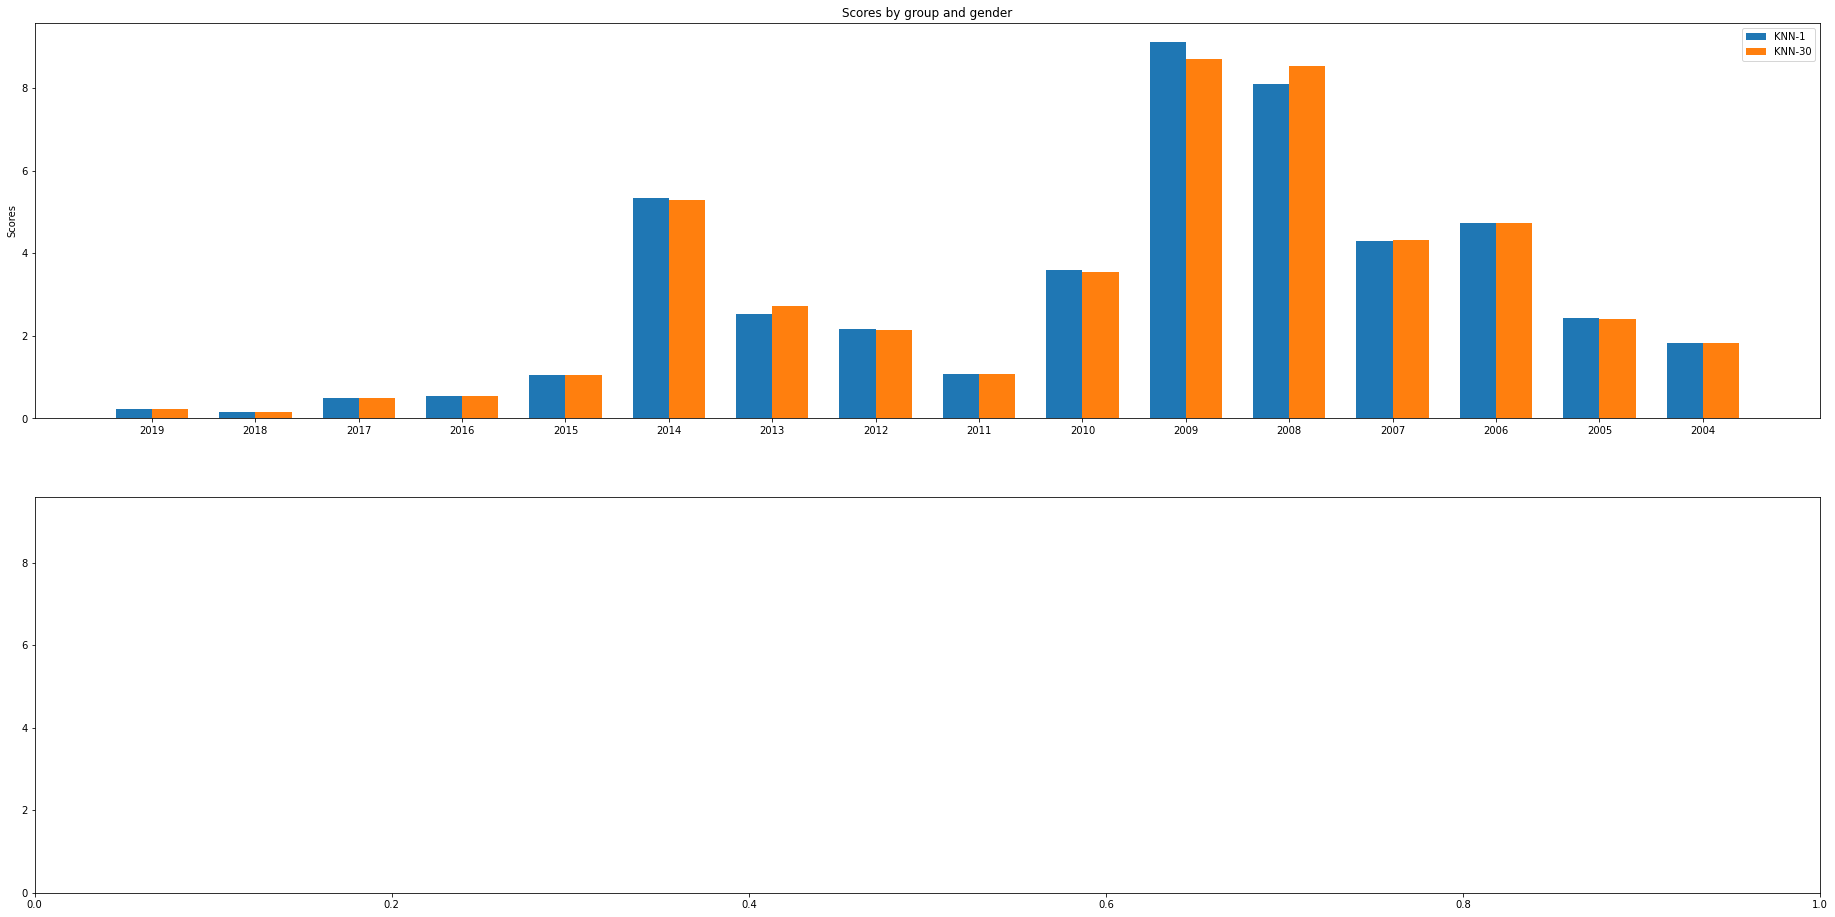

In [21]:
import matplotlib.pyplot as plt
import json
fig, axs = plt.subplots(2, 1, figsize=(32, 16), sharey=True)
#MSE
# MSE = json.loads(X2_new.loc['Thailand'].to_json())


#DATA
with open('results/mse_knn_1.json') as json_file:
    MSE1 = json.load(json_file)

with open('results/mse_knn_30.json') as json_file:
    MSE2 = json.load(json_file)
    
#SET UP PLOT
labels = list(MSE1.keys())
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(list(MSE2.values())))  # the label locations
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
rects1 = axs[0].bar(x - width/2, list(MSE1.values()), width, label='KNN-1')
rects2 = axs[0].bar(x + width/2, list(MSE2.values()), width, label='KNN-30')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Scores')
axs[0].set_title('Scores by group and gender')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].legend()
 
    
# axs[0].set_title('Mean Squred Error - KNN 1')
# width = 0.35  # the width of the bars
# axs[0].bar(list(MSE1.keys()), list(MSE1.values()))
# axs[0].bar(list(MSE2.keys()), list(MSE2.values()))

# axs[1].set_title('Mean Squred Error - KNN 30 ')
# axs[1].bar(list(MSE2.keys()), list(MSE2.values()))

# with open('results/mse_knn_30.json') as json_file:
#     MSE = json.load(json_file)
# axs[2].set_title('Mean Squred Error - KNN 30 ')
# axs[2].bar(list(MSE.keys()), list(MSE.values()))

# with open('results/mse_knn_60.json') as json_file:
#     MSE = json.load(json_file)
# axs[3].set_title('Mean Squred Error - KNN 60 ')
# axs[3].bar(list(MSE.keys()), list(MSE.values()))

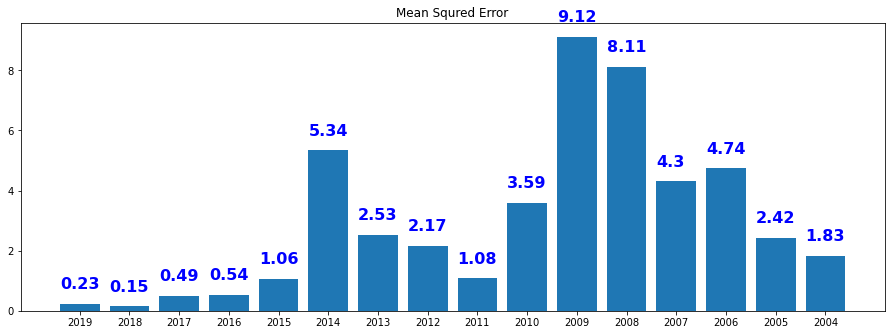

In [46]:
import matplotlib.pyplot as plt
import json
# fig, axs = plt.subplots(2, 1, figsize=(32, 16), sharey=True)

fig = plt.figure()
axs = fig.add_axes([0,0,2,1])

with open('results/mse_knn_1.json') as json_file:
    MSE = json.load(json_file)
axs.set_title('Mean Squred Error')
rects1 = axs.bar(list(MSE.keys()), list(MSE.values()))
for i, v in enumerate(list(MSE.values())):
    axs.text(i -0.4 ,v + .5,  str(round(v,2)), color='blue', fontweight='bold', fontsize = 16)

